<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
data = pd.read_csv('./train.csv')

In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
from sklearn.utils import shuffle
df = shuffle(data)
df.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1766,2,20.35,41.85,Female,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
5197,28,91.25,2483.65,Male,0,No,No,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
4344,72,24.30,1643.25,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),0
5026,25,25.30,676.35,Male,0,No,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),1
5,25,19.80,475.2,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0


In [6]:
all_columns = num_cols + cat_cols
values = []
#у 'TotalSpent' тип object, а не числовой, поменяем
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')

#for c in data.columns:
   # data[c] = pd.to_numeric(data[c], errors='coerce')

for column in all_columns:
    x = data[column].isna().sum() #sum(data[column] == np.nan)
    values.append(str(x))
table_nan = pd.DataFrame([values], columns = all_columns)

print(table_nan)

if data.isna().values.any():
    data = data.fillna(0)
        
if data.isna().values.any():
    print('Остались NaN')

  ClientPeriod MonthlySpending TotalSpent Sex IsSeniorCitizen HasPartner  \
0            0               0          9   0               0          0   

  HasChild HasPhoneService HasMultiplePhoneNumbers HasInternetService  \
0        0               0                       0                  0   

  HasOnlineSecurityService HasOnlineBackup HasDeviceProtection  \
0                        0               0                   0   

  HasTechSupportAccess HasOnlineTV HasMovieSubscription HasContractPhone  \
0                    0           0                    0                0   

  IsBillingPaperless PaymentMethod  
0                  0             0  


## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

2.816473988439306


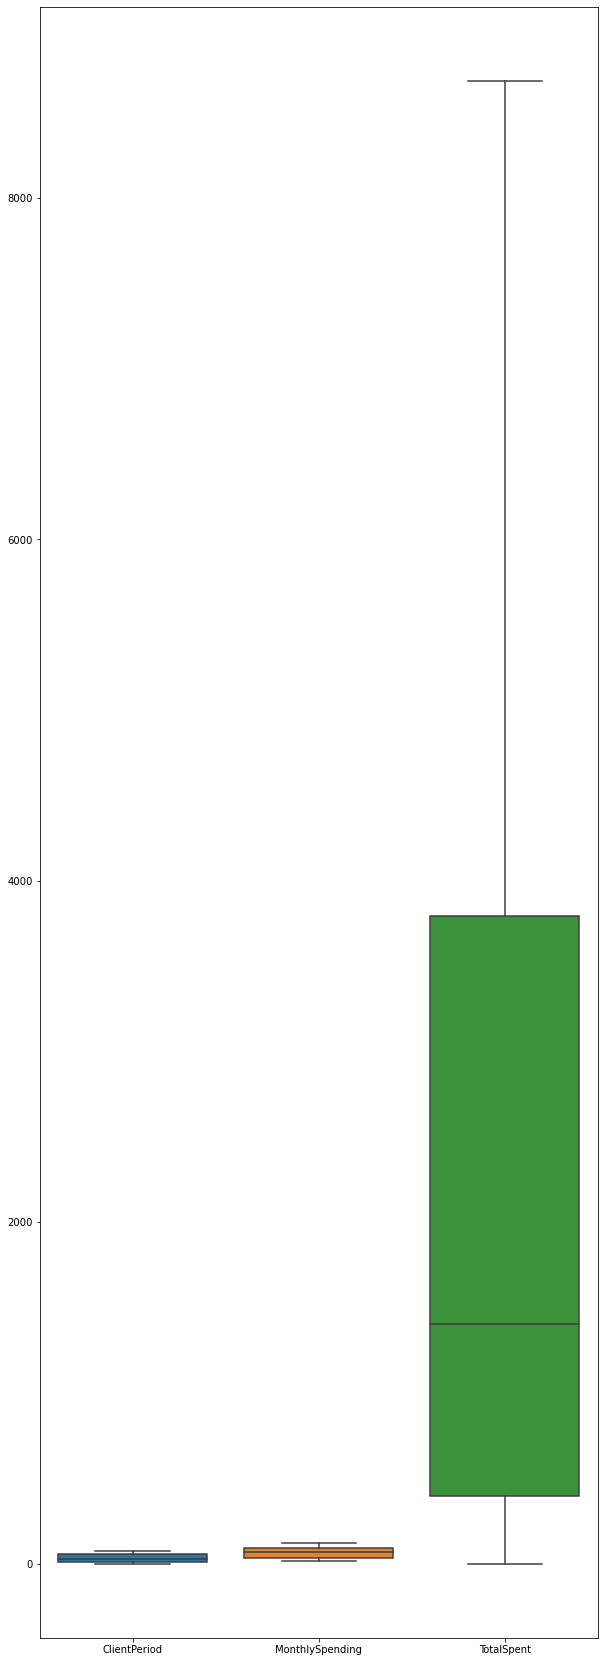

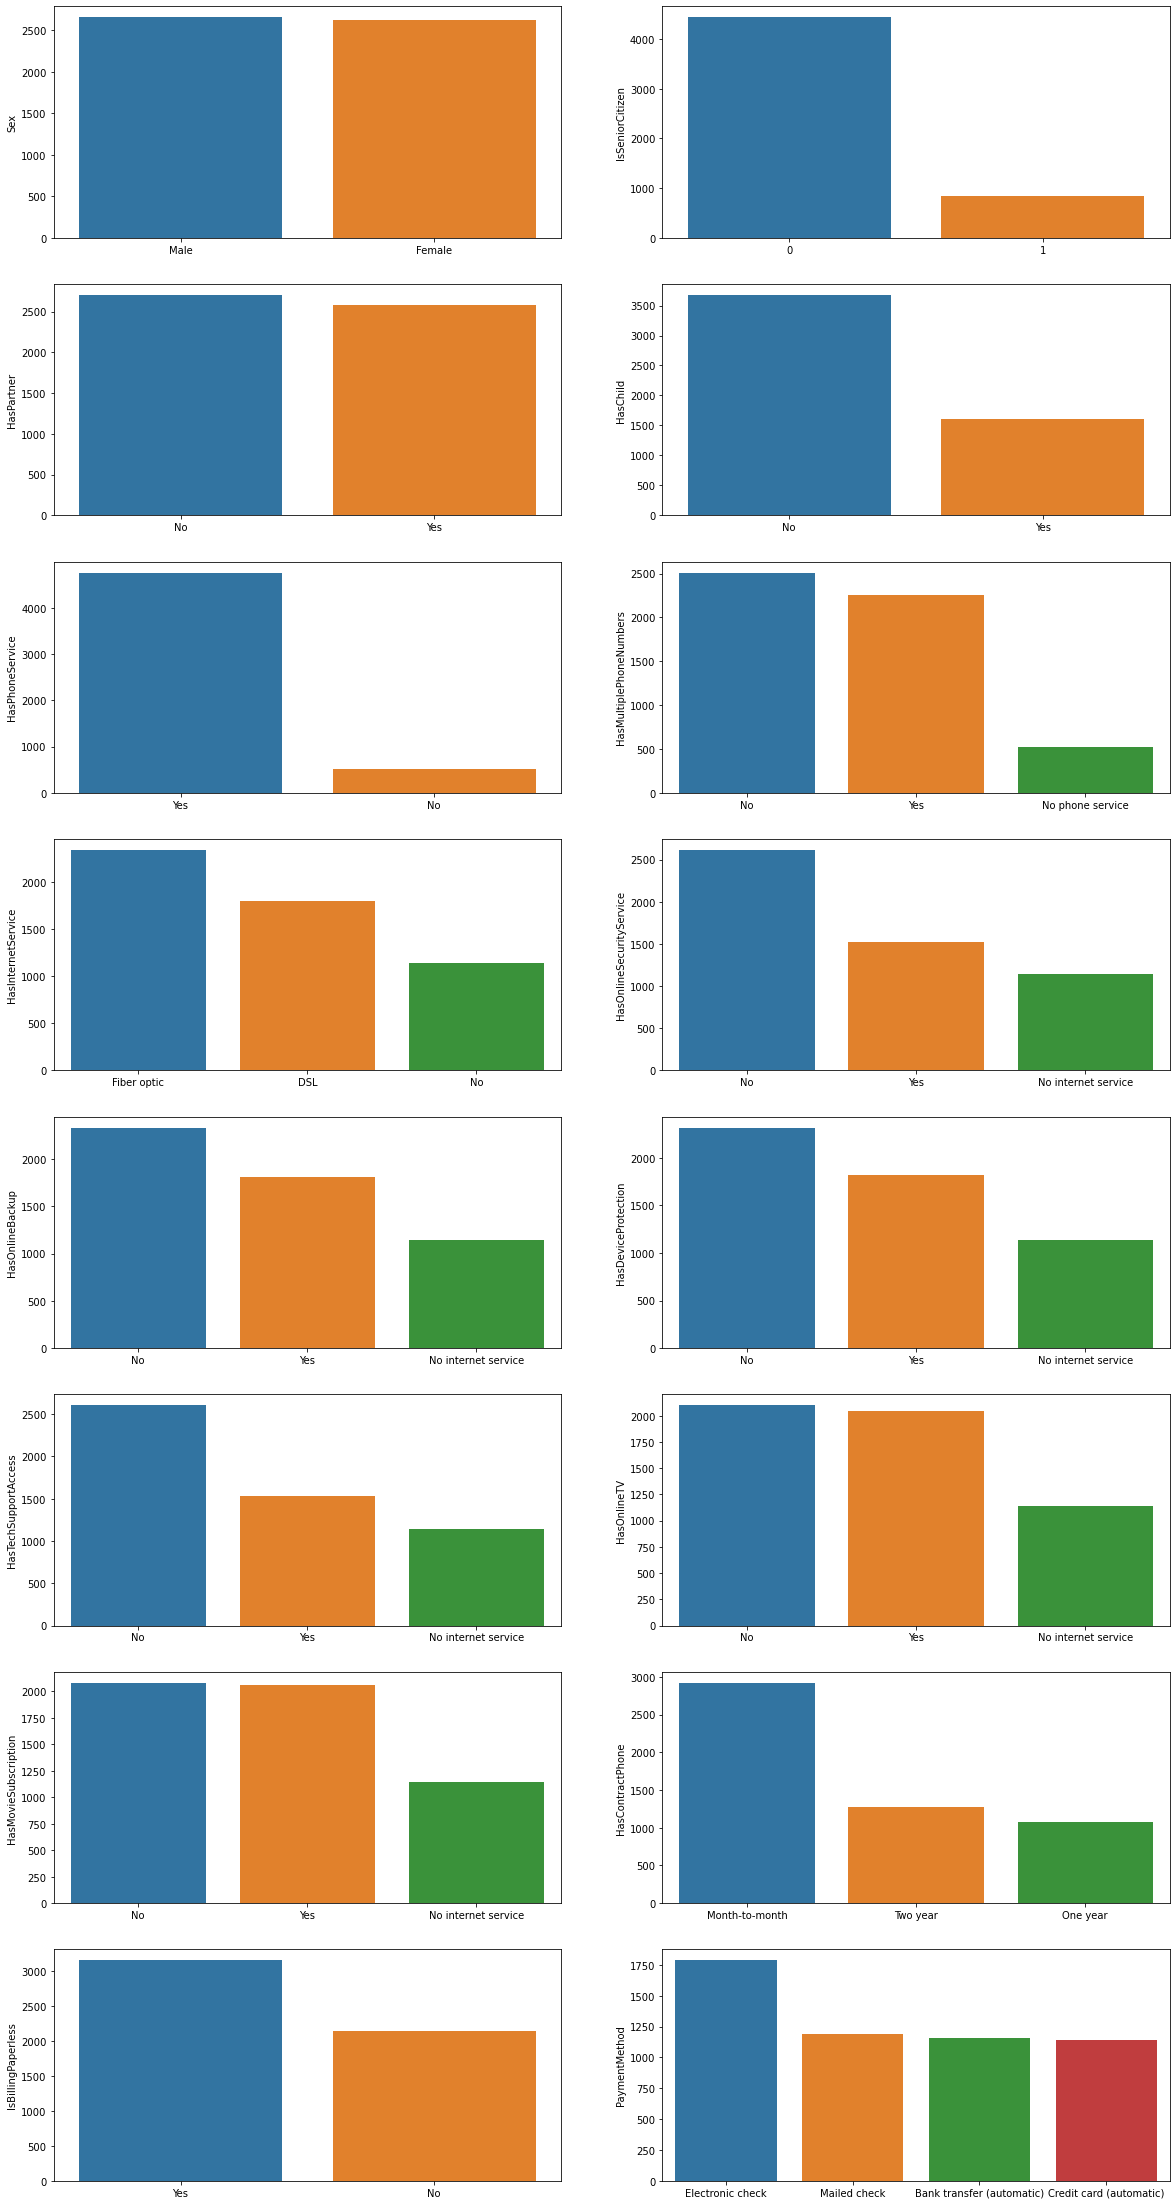

In [7]:
#print(data.dtypes)
#data[num_cols].boxplot()
import seaborn as sns
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(30)
sns.boxplot(data=data[num_cols])
fig, axes = plt.subplots(8, 2, figsize=(20, 40))
i = 0
j = 0
for column in cat_cols:
    x1 = data[column].value_counts()
    new = sns.barplot(ax=axes[i, j], x=x1.index, y=x1)
    j += 1
    if j == 2:
        i += 1
        j = 0
#распределение целевой переменной 
target_value1 = sum(data[target_col] == 0)
target_value2 = sum(data[target_col] == 1)
print(target_value1/target_value2)
#классы сбалансированные, так как разница не в 20 раз, а только в примерно 3 раза

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [8]:
# YOUR CODE

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [9]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

In [11]:
#1
data_1 = data
columns = ('ClientPeriod MonthlySpending TotalSpent '
           'Sex IsSeniorCitizen HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers HasInternetService HasOnlineSecurityService HasOnlineBackup HasDeviceProtection HasTechSupportAccess HasOnlineTV HasMovieSubscription HasContractPhone IsBillingPaperless PaymentMethod')

X = data_1.iloc[:,:-1]
y = data_1[target_col]
X.columns = columns.split()

u = []
for i in range(3,19):
    u.append(i)
categorial_indexes = np.array(u)
numeric_indexes = np.array([0,1,2])
categorial_data = X[X.columns[categorial_indexes]]
numeric_data = X[X.columns[numeric_indexes]]

#one-hot-encoding
categorial_data = pd.get_dummies(categorial_data)

#нормирование числовых признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_data = scaler.fit_transform(numeric_data)

X = pd.concat([pd.DataFrame(data=numeric_data), pd.DataFrame(data=categorial_data)], axis = 1)

#2
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size = 0.8, random_state=43)

lgcv = LogisticRegressionCV(cv=5, scoring='roc_auc', refit=True)
lgcv.fit(X_train, y_train)
print(roc_auc_score(y_test, lgcv.predict_proba(X_test)[:, 1]))
print(lgcv.C_)


0.8610920526014867
[2.7825594]


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

При С = 2.7825594
лучшее качество = 0.8610920526014867


## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [17]:
import catboost
X = data.iloc[:,:-1]
y = data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size = 0.8, random_state=42)

u = []
for i in range(3,19):
    u.append(i)
cat = catboost.CatBoostClassifier(n_estimators = 500, cat_features = u)
cat.fit(X_train, y_train)

Learning rate set to 0.035992
0:	learn: 0.6683784	total: 12ms	remaining: 6s
1:	learn: 0.6470650	total: 23.3ms	remaining: 5.79s
2:	learn: 0.6258346	total: 32ms	remaining: 5.31s
3:	learn: 0.6069034	total: 43ms	remaining: 5.33s
4:	learn: 0.5901903	total: 54ms	remaining: 5.34s
5:	learn: 0.5752954	total: 62.6ms	remaining: 5.15s
6:	learn: 0.5616510	total: 70.5ms	remaining: 4.96s
7:	learn: 0.5510308	total: 75.2ms	remaining: 4.63s
8:	learn: 0.5403899	total: 82.8ms	remaining: 4.52s
9:	learn: 0.5293302	total: 91.6ms	remaining: 4.49s
10:	learn: 0.5199618	total: 101ms	remaining: 4.48s
11:	learn: 0.5109213	total: 110ms	remaining: 4.47s
12:	learn: 0.5034417	total: 117ms	remaining: 4.4s
13:	learn: 0.4958331	total: 127ms	remaining: 4.41s
14:	learn: 0.4886116	total: 137ms	remaining: 4.42s
15:	learn: 0.4818517	total: 146ms	remaining: 4.42s
16:	learn: 0.4766521	total: 155ms	remaining: 4.39s
17:	learn: 0.4714068	total: 162ms	remaining: 4.35s
18:	learn: 0.4665799	total: 172ms	remaining: 4.36s
19:	learn: 0.

In [18]:
print(roc_auc_score(y_test, cat.predict_proba(X_test)[:,1]))

0.8226697204495711


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

При n_estimators = 1000
Лучшее качество 0.8267101338184908

# Предсказания

In [19]:
best_model = cat

In [22]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

#очистка от нулевых значений
X_test = X_test.dropna()

submission['Churn'] = best_model.predict_proba(X_test) / best_model.predict(X_test)
submission.to_csv('./my_submission.csv')

ValueError: operands could not be broadcast together with shapes (1761,2) (1761,) 

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.